In [1]:
import warnings  # suppress future warnings

import pandas as pd
import numpy as np
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Optional

from pandas.plotting import register_matplotlib_converters
pd.options.display.float_format = '{:.5f}'.format
register_matplotlib_converters()

# set settings for seaborn
sns.set_style(style="whitegrid", rc={"grid.color": ".9"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
title_font = {"fontname": "DejaVu Sans Mono"}

conn = psycopg2.connect("dbname = bikemi user=luca")

warnings.simplefilter(action="ignore", category=FutureWarning)


def retrieve_daily_data(connection, wide: bool = False) -> pd.DataFrame:
    query = """
        SELECT
            cdr.data_partenza,
            cdr.cluster,
            cdr.noleggi_giornalieri
        FROM bikemi_rentals.clusters_daily_rentals cdr
    """

    if not wide:
        return pd.read_sql(query, connection).rename(index=str.title)
    return (
        pd.read_sql(query, connection)
            .pivot(index="data_partenza", columns="cluster", values="noleggi_giornalieri")
            .rename(columns=str.title)
            .asfreq("D")
    )


daily_rentals: pd.DataFrame = retrieve_daily_data(conn, wide=True)

# Demand Forecasting

## Type of Forecast and Benchmark Model (Naïve Forecaster)

Forecast can be of two types: point forecast or distributional forecast. The demand forecasts in the bike-sharing literature are point forecast and, to the best of our knowledge, do not report confidence intervals. Indeed, distributional accuracy has seldom been the goal of forecasters. As an example, forecasting competitions have been held since the late 1970s at least and are nowadays quite popular - as much as they are controversial. However, the first forecasting competition to feature measurements of the prediction interval accuracy was the so-called M4, held in 2018 (Hyndman).

When assessing the performance of a model, a benchmark needs to be established. As benchmark models we choose naïve models instead of, say, fully-fledged ARIMA (auto-regressive, integrated moving average). For the most part, authors in the literature assess the performances of their models by simply pitting them against each other (analysis and prediction). This is the case when more models are trained. In the case of the deep-learning branch of the literature, more sophisticated machine learning models are fitted to establish a higher benchmark for the artificial neural network to beat. Ensemble methods such as random forest regressions are usually used, as they can capture non-linear relationships (Short-term prediction for bike-sharing service using machine learning).

 Naïve models seems more appropriate in the context of our analysis, as we are not interested in establishing a threshold in terms of the "best" model, but also the simplest and easiest to implement. After all, it would seem quite reasonable for the policymaker/BSS manager to implement a simple moving average model to forecast the number of bikes to make available at each stall at each time of the day.

## Metrics

To evaluate the performance of the models, one or more evaluation metrics are chosen. There are a plethora of metrics which have different meanings: the literature has not yet agreed upon a specific metric or set of metrics be used specifically for forecasting bike-sharing demand, and thus some of the most common error metrics are chosen. There is only one instance where fitting time was also taken into account (hamand, Analysis and prediction...)

In a way or another, evaluation metrics for point forecast are always a non-linear function $f(\hat{y}_t - y_y)$ of
the (sum of) prediction error, defined as $e_{t} = y_{t} - \hat{y}_{t}$. Often squares, squared roots and absolute values are involved, to return a positive value. Metrics can be of two types: scale-dependent and percentage. The difference between the two is that scale-dependent metrics cannot be used to compare performance on models trained on different datasets. A possible strategy to work around this problem is to divide the original series by its maximum value: this turns scale-dependent metrics into de-facto percentage errors, that are easier to interpret.

### Scale Dependent Metrics

The first and by far most popular error metrics are the mean absolute error (MAE) and the root mean squared error (RMSE). These are defined as such:

\begin{align}
&MAE = \frac{1}{n}\sum_{j = 1}^n \left| {{y_j} - {{\hat y}_j}} \right|\\
&RMSE=\sqrt{\frac{1}{n}\sum_{j=1}^{n}(\hat{y}_{i}-y_{i})^{2}}\\
\end{align}

These metrics are widely used, and virtually all papers in the literature employ either (MAE seems to be prevalent).

Another "niche" metric is sometimes used: it is the root mean squared logarithmic error, or RMSLE. This is defined as:

\begin{align}
&RMSLE =\sqrt{\frac{1}{n}\sum_{i=1}^{N}(log(\hat{y}_{i}+1)-\log(y_{i}+1))^{2}}
\end{align}

We could track the (possibly) first usage of this metric in the field thanks to a [Kaggle competition held in 2014](https://www.kaggle.com/c/bike-sharing-demand) (Multi agent...). Kaggle "was the first online platform dedicated to data mining competitions; it was established in 2010 by Australian economist Anthony Goldbloom" History of forecasting. The "fundamental reason" behind RMSLE is that "the logarithmic-based calculation ensures that the errors during peak hours do not dominate the errors made during off-peak hours" (multi agent). This is also the case for which MAE is also preferred: "We choose MAE instead of MSE because MAE is more stable to outliers and so does the case in MSLE vs. MAPE" (Prediction of station).

However, it is worth noting that "A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean. Consequently, the RMSE is also widely used, despite being more difficult to interpret" HYNDMAN

### Percentage Metrics

The advantage of percentage errors is that they are unit-free and can be used to compare performance across different datasets. This case might be of our interst, since we might want to apply the same model architectures to the different time series of the stations. The most common percentage metric employed is the Mean absolute percentage error, or MAPE, which is defined as follows:

\begin{align}
&MAPE= \frac{1}{n}\sum_{i=1}^{n}\left\vert \frac{\hat{y}_{i}-y_{i}}{y_{i}}\right\vert
\end{align}

The disadvantage of MAPE is that it may involve divisions by zero, yielding undefined terms (or, when the ground truth is close to zero, infinite error). This makes the MAPE less popular in the bike-sharing services (BSS) literature, especially with hourly forecasts as the demand will be zero during the hours when the service is not active.

To circumvent this problem, Hyndman and Koheler (Another look at measures of forecast accuracy) proposed to use *scaled* error metrics. Simply put, the MAE is computed and then is scaled by the *training* MAE of a simple forecast method. The scaled error $q_j$ is defined as such:

\begin{align}
q_{j} = \frac{\displaystyle e_{j}}
    {\displaystyle\frac{1}{T-1}\sum_{t=2}^T |y_{t}-y_{t-1}|}.
\end{align}

And then the mean absolute scaled error (MASE) and root mean squared scaled error (RMSSE) are defined as such:

\begin{align}
& MASE = \text{mean}(|q_{j}|) \\
& RMSSE = \sqrt{\text{mean}(q_{j}^2)}
\end{align}

MASE and RMSSE are not available in vanilla scikit-learn, as they require fitting a naive model. They are, however, available in sktime, the scikit-learn-compatible time series library developed at the Alan Turing Institute.

In [2]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_squared_log_error,
    mean_absolute_percentage_error,
)


def model_diagnostics(y_pred: pd.Series, y_true: pd.Series) -> pd.DataFrame:
    cols = ["MAE", "RMSE", "RMSLE"]

    scores = [
        mean_absolute_error(y_true, y_pred),
        mean_squared_error(y_true, y_pred, squared=True),
        mean_squared_log_error(y_true, y_pred, squared=True),
    ]
    return pd.DataFrame({"metrics": cols, "scores": scores}).round(5)

## Cross Validation

The forecasting horizon is the number of data points that the want to forecast. The longer the horizon, the larger the prediction interval becomes; however, since we are just interested in the point forecast this does not concern us as much. There is no consensus on the literature on the kind of forecasting horizon `fh` to be used: this, of course, varies according to the frequency of the data. Sometimes, deep learning models are used to forecast the demand at the next hour, as they are intended to be later deployed as real-time applications. Since we have daily data, we shall use a 7 day forecasting horizon.

In [3]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

cv_generator = SlidingWindowSplitter(fh=np.arange(1, 8),
                                     step_length=1,
                                     window_length=90
                                     )


def get_cv_predictions(evaluated_cv: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([evaluated_cv["y_pred"][k] for k in range(evaluated_cv.shape[0])], axis=1).apply(np.mean, axis=1)

Unlike normal CV, time series CV might have different folds (windows) forecasting the same time step.

## Naïve Forecaster

As naive forecaster, we choose a seasonal model, with which we set each forecast to be equal to the last observed value from the same season of the year.

In [4]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

y = daily_rentals["Brera - 25"]
y_true = daily_rentals["Brera - 25"][90:]

naive_forecaster = NaiveForecaster(strategy="last",
                                   sp=7)  # weekly seasonal periodicity

In [5]:
from sktime.forecasting.model_evaluation import evaluate

naive_fit = evaluate(naive_forecaster, cv_generator, y, return_data=True)
naive_preds = get_cv_predictions(naive_fit)

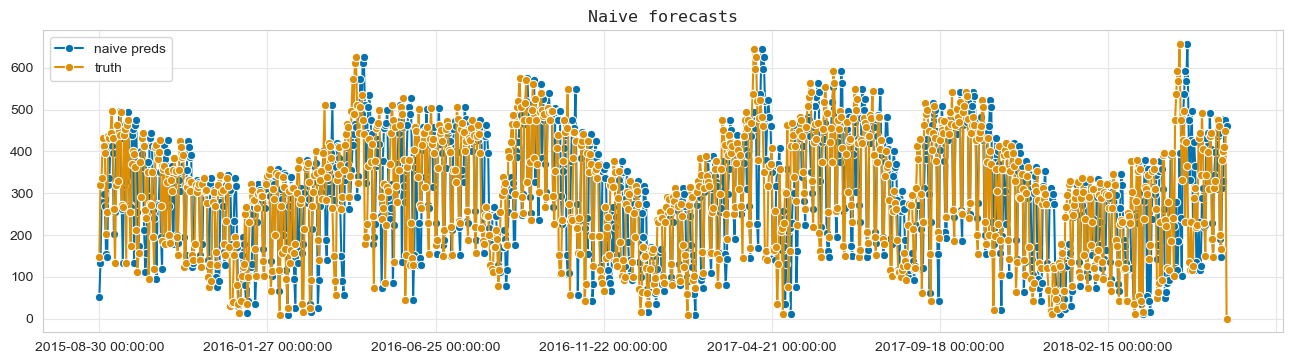

In [6]:
naive_fig = plot_series(naive_preds, y_true, labels=["naive preds", "truth"])
plt.title("Naive forecasts", **title_font)
plt.show(naive_fig)

In [7]:
naive_diagnostics = model_diagnostics(naive_preds, y_true)

naive_diagnostics


,metrics,scores
0,MAE,87.96922
1,RMSE,14255.89573
2,RMSLE,0.42915


## Models

## Rand forest

RandomForest was introduced in 2001 by Leo Breiman[27], while Gradient Boosting Regression Tree was developed by Friedman[28][29]–[30] based on the work of Leo Breiman.Both algorithms can fit trees by selecting a random subset of the predictors from the original data and outputs a classification or a regression prediction.However, GBRT sequentially fits the trees.A robust model is built by minimizing the errors of the previous trees each time a tree is added (analysis and prediction)

### Configurations
multi agent system Salamanca:
Extra Tree Regressor: learning rate: [0.1, 0.01, 0.001], subsample: [1.0, 0.9, 0.8], max depth: [3, 5, 7], min samples leaf: [1, 3, 5]
Random Forest Regressor: criterion: [mae, mse], number estimators: [10, 100, 1000], max features: [auto, sqrt, log2]
Gradient Boosting Regressor: learning rate: [0.1, 0.01, 0.001], subsample: [1.0, 0.9, 0.8], max depth: [3, 5, 7], min samples leaf: [1, 3, 5]







## Cross valitation

A comparative study of performance estimation & hyndman

The data used is a time-series data, hence, the time-series split by the sklearn library was used. It splits the data at a fixed interval without shuffling Analysis and prediction k-fold

There are three main techniques to avoid over-fitting (1) cross-validation
methods (see Hastie et al. (2009)); (2) methods which penalize the complexity of the model;
(e.g. AIC, Akaike (1974) or BIC, Schwartz (1978)) (3) regularization methods such as Ridge
Regression and Lasso (see Hastie et al. (2009))


## Prophet

In [ ]:
from sktime.forecasting.fbprophet import Prophet

forecaster = Prophet(
    seasonality_mode='multiplicative',
    n_changepoints=int(len(y) / 12),
    add_country_holidays={'country_name': 'Germany'},
    yearly_seasonality=True)
forecaster.fit(y)

ARIMA & Auto ARIMA?

## Multivariate

### feature generation

### Encoding of categoricals

In [ ]:
gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
    ),
    HistGradientBoostingRegressor(
        categorical_features=range(4),
    ),
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor